In [1]:
import numpy as np
import pandas as pd
import random
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
dataframe = pd.read_csv("SP500DATA.csv")
print(dataframe)# Text file data converted to integer data type
Shillerdataframe = pd.read_csv("S&P500 Schiller PE ratio.csv")
print(Shillerdataframe)

           Date    Price     Open     High      Low Vol.  Change %
0    01/12/2021  4766.18  4623.80  4808.52  4494.20    -    0.0436
1    01/11/2021  4567.00  4616.47  4743.74  4560.26    -   -0.0083
2    01/10/2021  4605.38  4324.71  4608.70  4278.70    -    0.0691
3    01/09/2021  4307.54  4531.04  4544.58  4304.90    -   -0.0476
4    01/08/2021  4522.68  4415.90  4537.80  4369.20    -    0.0290
..          ...      ...      ...      ...      ...  ...       ...
618  01/06/1970    72.72    76.55    79.96    72.25    -   -0.0500
619  01/05/1970    76.55    81.52    82.32    68.61    -   -0.0610
620  01/04/1970    81.52    89.63    90.70    79.31    -   -0.0905
621  01/03/1970    89.63    89.50    91.07    86.19    -    0.0015
622  01/02/1970    89.50    85.02    90.33    84.64    -    0.0527

[623 rows x 7 columns]
                 DateTime  SP500PERatio
0     1871-01-01 00:00:58         11.10
1     1871-02-01 00:00:58         11.25
2     1871-03-01 00:00:58         11.52
3     1871-0

# Step 1

In [2]:
trainData = dataframe[["Price", "Open"]].to_numpy(dtype = 'float')
targetData = dataframe[["Price"]].to_numpy(dtype = 'float')
date = dataframe[["Date"]].to_numpy(dtype = "str")

norm = MinMaxScaler(feature_range = (0, 1))
trainData = norm.fit_transform(trainData)
targetData = norm.fit_transform(targetData)
trainData = np.flip(trainData)
targetData = np.flip(targetData)
date = np.flip(date)

dateAxis = []
for i in range(date.shape[0]):
    dateAxis.append(float(np.squeeze(date)[i][6:10]) + float(np.squeeze(date)[i][3:5])/12.0)
dateAxis = np.array(dateAxis)
dateAxis_test=date[438:623,:]
dateAxis = dateAxis[6:620]
print(dateAxis.shape)

(614,)


In [3]:
X = []
Y = []
for i in range(trainData.shape[0] - 5 - 4):
    X.append(trainData[i:i+6])
    Y.append(targetData[i+6:i+6+4])
X = np.array(X)
Y = np.array(Y)
Y = np.swapaxes(Y, 1, 2)
Y.shape

(614, 1, 4)

In [4]:
X_fullTraining = []
X_training = []
X_validation = []
X_test = []
Y_fullTraining = []
Y_training = []
Y_validation = []
Y_test = []

X_fullTraining, X_test, Y_fullTraining, Y_test, date_ft, date_t = train_test_split(X, Y, dateAxis, test_size=0.3, shuffle=False)
X_training, X_validation, Y_training, Y_validation, date_tr, date_v = train_test_split(X_fullTraining, Y_fullTraining, date_ft, test_size=0.3, shuffle=False)

date_test=date[438:623,:]

-31.1 653.1


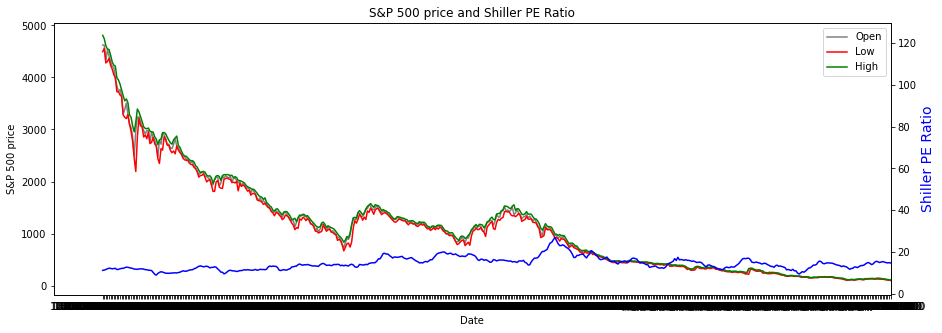

In [40]:
plt.figure(figsize=(15, 5));
plt.plot(dataframe.Date, dataframe.Open.values, color='grey', label='Open')
# plt.plot(dataframe.Date, dataframe.Close.values, color='black', label='Close')
plt.plot(dataframe.Date, dataframe.Low.values, color='red', label='Low')
plt.plot(dataframe.Date, dataframe.High.values, color='green', label='High')
plt.title('S&P 500 price and Shiller PE Ratio')
plt.xlabel('Date')
plt.ylabel('S&P 500 price')
plt.legend(loc='best')
# twin object for two different y-axis on the sample plot
ax2=plt.twinx()
plt.xlim(-31.1,500.1)
# make a plot with different y-axis using second axis object
ax2.plot(Shillerdataframe.DateTime, Shillerdataframe.SP500PERatio.values,color="blue")
ax2.set_ylabel("Shiller PE Ratio", color="blue",fontsize=14)
plt.show()

# Step 2

In [6]:
class Model(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(Model, self).__init__()

        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)   

        self.fc = nn.Linear(hidden_dim, output_size)
    
    def forward(self, x):
        
        batch_size = x.size(0)

        hidden = self.init_hidden(batch_size)

        out, hidden = self.rnn(x, hidden)
    
        out = self.fc(out)
    
        return out[:, -1, :], hidden
    
    def init_hidden(self, batch_size):
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_dim)
        return hidden

In [7]:
RNN = Model(input_size=2, output_size=4, hidden_dim=16, n_layers=1)
optimizer = torch.optim.Adam(RNN.parameters(), lr=0.01)
criterion = nn.MSELoss()
RNN

Model(
  (rnn): RNN(2, 16, batch_first=True)
  (fc): Linear(in_features=16, out_features=4, bias=True)
)

# Step 3

In [8]:
xTensor = torch.from_numpy(X_fullTraining).float()
yTensor = torch.Tensor(Y_fullTraining).float()

for epoch in range(100):
    optimizer.zero_grad()
    
    output, hidden = RNN(xTensor)
    loss = criterion(output.reshape(-1), yTensor.view(-1))
    loss.backward()
    
    optimizer.step()
    
    if epoch%10 == 0:
        print('Epoch: {}/{}.............'.format(epoch, 100), end=' ')
        print("Loss:", loss.item())

Epoch: 0/100............. Loss: 0.01888134516775608
Epoch: 10/100............. Loss: 0.0061526792123913765
Epoch: 20/100............. Loss: 0.0019144890829920769
Epoch: 30/100............. Loss: 0.0003939233429264277
Epoch: 40/100............. Loss: 0.00017066246073227376
Epoch: 50/100............. Loss: 0.00016861382755450904
Epoch: 60/100............. Loss: 0.00010678168473532423
Epoch: 70/100............. Loss: 9.654230234446004e-05
Epoch: 80/100............. Loss: 9.251583833247423e-05
Epoch: 90/100............. Loss: 9.010449139168486e-05


In [9]:
def prediction_error(pred, actual):
    return abs(pred - actual)/pred

In [10]:
output_plt1 = output.detach().numpy()[:, 0]
output_plt1 = norm.inverse_transform(output_plt1.reshape(-1,1))

output_plt2 = output.detach().numpy()[:, 1]
output_plt2 = norm.inverse_transform(output_plt2.reshape(-1,1))

output_plt3 = output.detach().numpy()[:, 2]
output_plt3 = norm.inverse_transform(output_plt3.reshape(-1,1))

output_plt4 = output.detach().numpy()[:, 3]
output_plt4 = norm.inverse_transform(output_plt4.reshape(-1,1))

Y_plt = norm.inverse_transform(Y[:, :, 0])
Y_fullTrainingplt = norm.inverse_transform(Y_fullTraining[:, :, 0])

,Mean,STD-dev,Skewness,Kurtosis
1 day,0.044018,0.038075,1.639880,4.352026
2 day,0.053451,0.044389,1.430796,2.961270
3 day,0.044062,0.038175,1.734473,4.896950
4 day,0.052853,0.044436,1.488618,3.286538


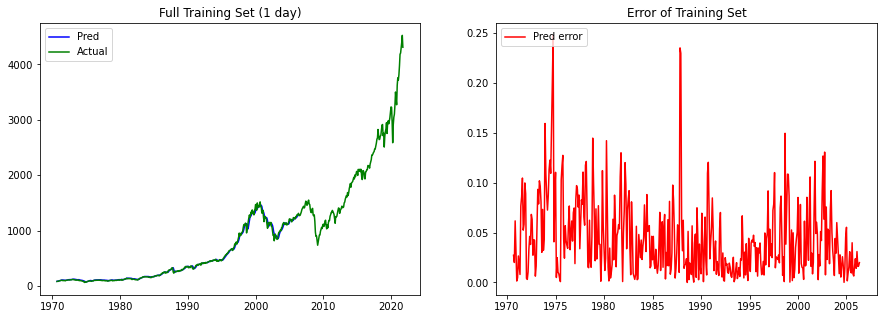

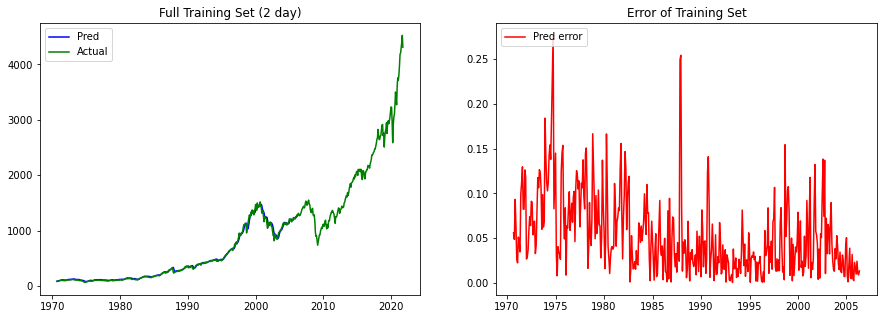

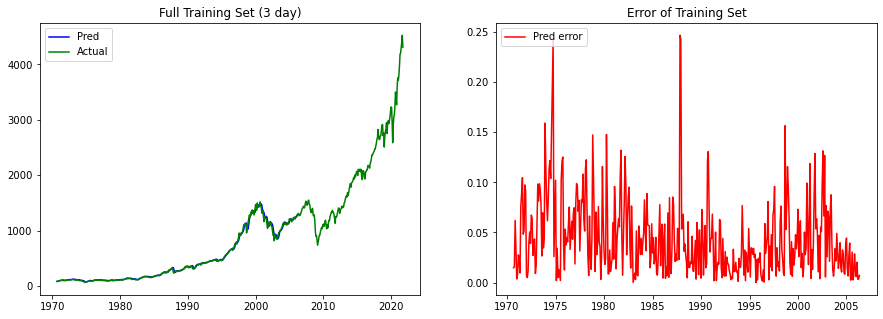

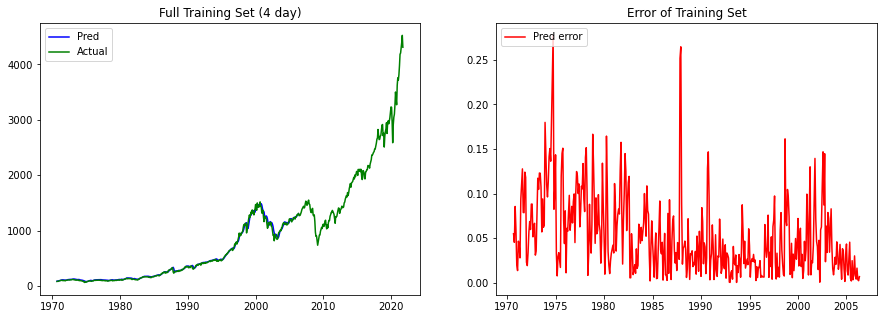

In [11]:
table = []

error = prediction_error(output_plt1, Y_fullTrainingplt)
error_dt = pd.DataFrame(data = error)
temp1 = [np.mean(error), np.std(error), error_dt.skew(axis=0).iloc[0], error_dt.kurtosis(axis=0).iloc[0]]
temp1 = np.array(temp1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title("Full Training Set (1 day)")
ax1.plot(date_ft, output_plt1, color = 'blue', label = 'Pred')
ax1.plot(dateAxis, Y_plt, color = 'green', label = 'Actual')
ax1.legend(loc="upper left")
ax2.set_title("Error of Training Set")
ax2.plot(date_ft, error, color = 'red', label = 'Pred error')
ax2.legend(loc="upper left")

error = prediction_error(output_plt2, Y_fullTrainingplt)
error_dt = pd.DataFrame(data = error)
temp2 = [np.mean(error), np.std(error), error_dt.skew(axis=0).iloc[0], error_dt.kurtosis(axis=0).iloc[0]]
temp2 = np.array(temp2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title("Full Training Set (2 day)")
ax1.plot(date_ft, output_plt2, color = 'blue', label = 'Pred')
ax1.plot(dateAxis, Y_plt, color = 'green', label = 'Actual')
ax1.legend(loc="upper left")
ax2.set_title("Error of Training Set")
ax2.plot(date_ft, error, color = 'red', label = 'Pred error')
ax2.legend(loc="upper left")

error = prediction_error(output_plt3, Y_fullTrainingplt)
error_dt = pd.DataFrame(data = error)
temp3 = [np.mean(error), np.std(error), error_dt.skew(axis=0).iloc[0], error_dt.kurtosis(axis=0).iloc[0]]
temp3 = np.array(temp3)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title("Full Training Set (3 day)")
ax1.plot(date_ft, output_plt3, color = 'blue', label = 'Pred')
ax1.plot(dateAxis, Y_plt, color = 'green', label = 'Actual')
ax1.legend(loc="upper left")
ax2.set_title("Error of Training Set")
ax2.plot(date_ft, error, color = 'red', label = 'Pred error')
ax2.legend(loc="upper left")

error = prediction_error(output_plt4, Y_fullTrainingplt)
error_dt = pd.DataFrame(data = error)
temp4 = [np.mean(error), np.std(error), error_dt.skew(axis=0).iloc[0], error_dt.kurtosis(axis=0).iloc[0]]
temp4 = np.array(temp4)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title("Full Training Set (4 day)")
ax1.plot(date_ft, output_plt4, color = 'blue', label = 'Pred')
ax1.plot(dateAxis, Y_plt, color = 'green', label = 'Actual')
ax1.legend(loc="upper left")
ax2.set_title("Error of Training Set")
ax2.plot(date_ft, error, color = 'red', label = 'Pred error')
ax2.legend(loc="upper left")

temp1 = np.expand_dims(temp1, axis=1)
temp2 = np.expand_dims(temp2, axis=1)
temp3 = np.expand_dims(temp3, axis=1)
temp4 = np.expand_dims(temp4, axis=1)
table = np.concatenate((temp1, temp2, temp3, temp4), axis=1)
ind = ['Mean', 'STD-dev', 'Skewness', 'Kurtosis']
col = ['1 day', '2 day', '3 day', '4 day']
stats=pd.DataFrame(table, columns=col, index=ind).T
stats

# Step 4 

In [12]:
RNN.eval()
xTensor = torch.from_numpy(X_test).float()
output, _ = RNN(xTensor)

output_plt1 = output.detach().numpy()[:, 0]
output_plt1 = norm.inverse_transform(output_plt1.reshape(-1,1))

output_plt2 = output.detach().numpy()[:, 1]
output_plt2 = norm.inverse_transform(output_plt2.reshape(-1,1))

output_plt3 = output.detach().numpy()[:, 2]
output_plt3 = norm.inverse_transform(output_plt3.reshape(-1,1))

output_plt4 = output.detach().numpy()[:, 3]
output_plt4 = norm.inverse_transform(output_plt4.reshape(-1,1))

Y_testplt = norm.inverse_transform(Y_test[:, :, 0])

,Mean,STD-dev,Skewness,Kurtosis
1 day,0.078314,0.068711,1.622355,2.474978
2 day,0.063297,0.051138,1.392075,1.598249
3 day,0.057683,0.047480,1.471874,1.820481
4 day,0.072250,0.064542,1.629360,2.244397


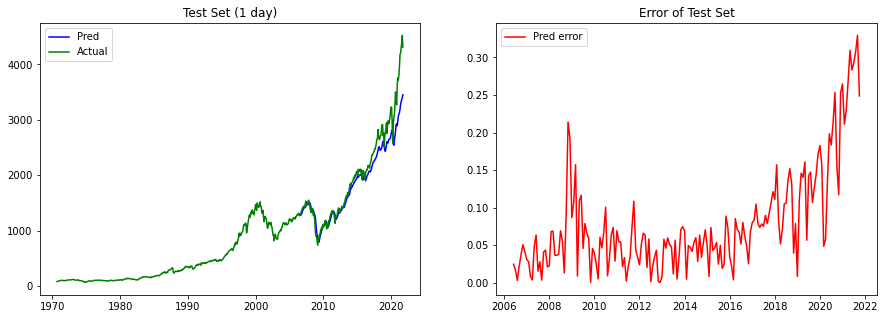

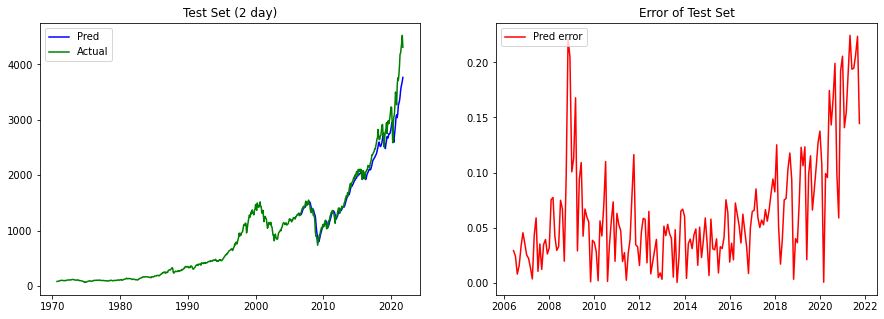

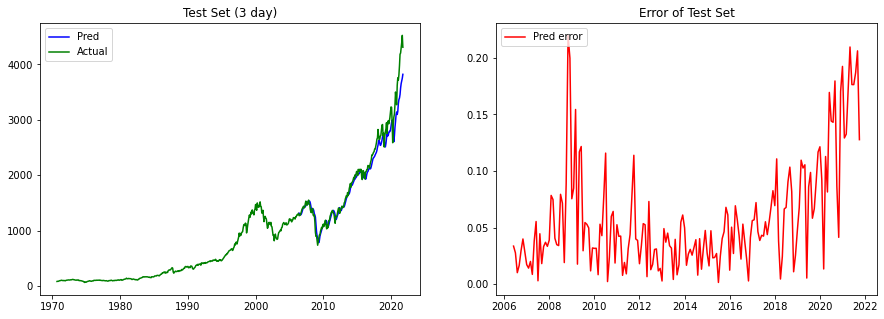

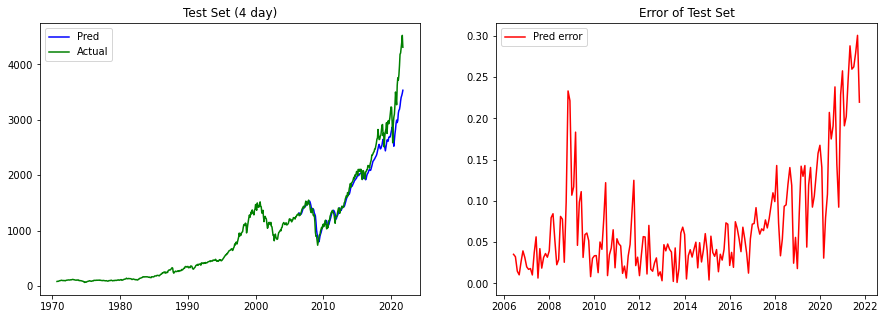

In [13]:
table = []

error = prediction_error(output_plt1, Y_testplt)
error_dt = pd.DataFrame(data = error)
temp1 = [np.mean(error), np.std(error), error_dt.skew(axis=0).iloc[0], error_dt.kurtosis(axis=0).iloc[0]]
temp1 = np.array(temp1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title("Test Set (1 day)")
ax1.plot(date_t, output_plt1, color = 'blue', label = 'Pred')
ax1.plot(dateAxis, Y_plt, color = 'green', label = 'Actual')
ax1.legend(loc="upper left")
ax2.set_title("Error of Test Set")
ax2.plot(date_t, error, color = 'red', label = 'Pred error')
ax2.legend(loc="upper left")

error = prediction_error(output_plt2, Y_testplt)
error_dt = pd.DataFrame(data = error)
temp2 = [np.mean(error), np.std(error), error_dt.skew(axis=0).iloc[0], error_dt.kurtosis(axis=0).iloc[0]]
temp2 = np.array(temp2)
    
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title("Test Set (2 day)")
ax1.plot(date_t, output_plt2, color = 'blue', label = 'Pred')
ax1.plot(dateAxis, Y_plt, color = 'green', label = 'Actual')
ax1.legend(loc="upper left")
ax2.set_title("Error of Test Set")
ax2.plot(date_t, error, color = 'red', label = 'Pred error')
ax2.legend(loc="upper left")

error = prediction_error(output_plt3, Y_testplt)
error_dt = pd.DataFrame(data = error)
temp3 = [np.mean(error), np.std(error), error_dt.skew(axis=0).iloc[0], error_dt.kurtosis(axis=0).iloc[0]]
temp3 = np.array(temp3)
    
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title("Test Set (3 day)")
ax1.plot(date_t, output_plt3, color = 'blue', label = 'Pred')
ax1.plot(dateAxis, Y_plt, color = 'green', label = 'Actual')
ax1.legend(loc="upper left")
ax2.set_title("Error of Test Set")
ax2.plot(date_t, error, color = 'red', label = 'Pred error')
ax2.legend(loc="upper left")

error = prediction_error(output_plt4, Y_testplt)
error_dt = pd.DataFrame(data = error)
temp4 = [np.mean(error), np.std(error), error_dt.skew(axis=0).iloc[0], error_dt.kurtosis(axis=0).iloc[0]]
temp4 = np.array(temp4)
                  
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title("Test Set (4 day)")
ax1.plot(date_t, output_plt4, color = 'blue', label = 'Pred')
ax1.plot(dateAxis, Y_plt, color = 'green', label = 'Actual')
ax1.legend(loc="upper left")
ax2.set_title("Error of Test Set")
ax2.plot(date_t, error, color = 'red', label = 'Pred error')
ax2.legend(loc="upper left")


temp1 = np.expand_dims(temp1, axis=1)
temp2 = np.expand_dims(temp2, axis=1)
temp3 = np.expand_dims(temp3, axis=1)
temp4 = np.expand_dims(temp4, axis=1)
table = np.concatenate((temp1, temp2, temp3, temp4), axis=1)
ind = ['Mean', 'STD-dev', 'Skewness', 'Kurtosis']
col = ['1 day', '2 day', '3 day', '4 day']
stats=pd.DataFrame(table, columns=col, index=ind).T
stats

# Step 5

In [14]:
RNNval = Model(input_size=2, output_size=4, hidden_dim=32, n_layers=2)
optimizerVal = torch.optim.Adam(RNNval.parameters(), lr=0.002)
criterionVal = nn.MSELoss()
RNNval

xTensor = torch.from_numpy(X_training).float()
yTensor = torch.Tensor(Y_training).float()

for epoch in range(200):
    optimizerVal.zero_grad()
    
    output, hidden = RNNval(xTensor)
    loss = criterionVal(output.reshape(-1), yTensor.view(-1))
    loss.backward()
    
    optimizerVal.step()
    
    if epoch%100 == 0:
        print('Epoch: {}/{}.............'.format(epoch, 200), end=' ')
        print("Loss:", loss.item())

Epoch: 0/200............. Loss: 0.044775575399398804
Epoch: 100/200............. Loss: 2.2749987692805007e-05


In [15]:
output_plt1 = output.detach().numpy()[:, 0]
output_plt1 = norm.inverse_transform(output_plt1.reshape(-1,1))

output_plt2 = output.detach().numpy()[:, 1]
output_plt2 = norm.inverse_transform(output_plt2.reshape(-1,1))

output_plt3 = output.detach().numpy()[:, 2]
output_plt3 = norm.inverse_transform(output_plt3.reshape(-1,1))

output_plt4 = output.detach().numpy()[:, 3]
output_plt4 = norm.inverse_transform(output_plt4.reshape(-1,1))

Y_plt = norm.inverse_transform(Y[:, :, 0])
Y_trainingplt = norm.inverse_transform(Y_training[:, :, 0])

,Mean,STD-dev,Skewness,Kurtosis
1 day,0.051901,0.043753,1.566685,4.296847
2 day,0.053093,0.044264,1.631305,4.688983
3 day,0.055784,0.045650,1.644778,4.771959
4 day,0.057478,0.046017,1.635917,4.680848


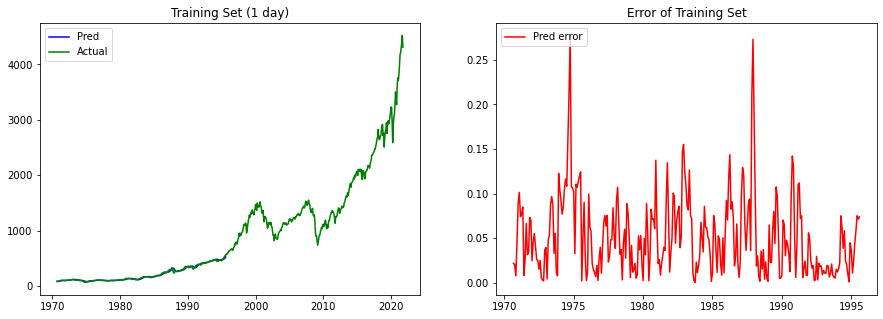

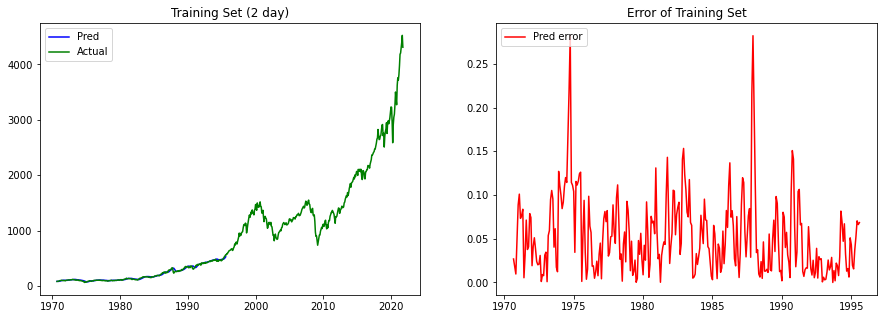

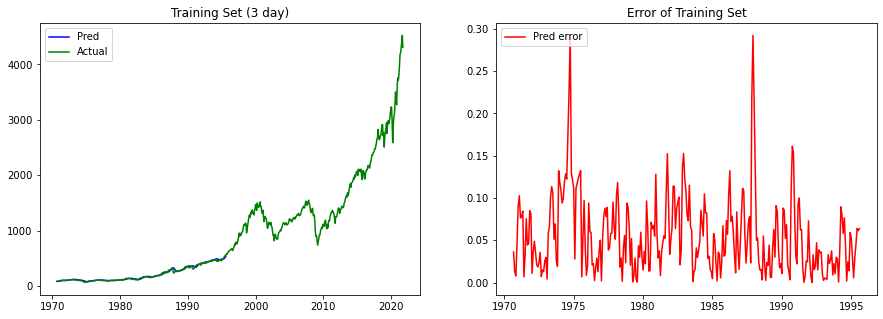

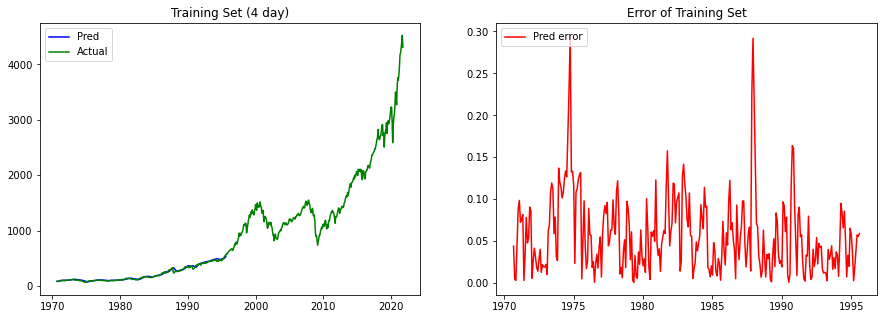

In [16]:
table = []

error = prediction_error(output_plt1, Y_trainingplt)
error_dt = pd.DataFrame(data = error)
temp1 = [np.mean(error), np.std(error), error_dt.skew(axis=0).iloc[0], error_dt.kurtosis(axis=0).iloc[0]]
temp1 = np.array(temp1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title("Training Set (1 day)")
ax1.plot(date_tr, output_plt1, color = 'blue', label = 'Pred')
ax1.plot(dateAxis, Y_plt, color = 'green', label = 'Actual')
ax1.legend(loc="upper left")
ax2.set_title("Error of Training Set")
ax2.plot(date_tr, error, color = 'red', label = 'Pred error')
ax2.legend(loc="upper left")

error = prediction_error(output_plt2, Y_trainingplt)
error_dt = pd.DataFrame(data = error)
temp2 = [np.mean(error), np.std(error), error_dt.skew(axis=0).iloc[0], error_dt.kurtosis(axis=0).iloc[0]]
temp2 = np.array(temp2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title("Training Set (2 day)")
ax1.plot(date_tr, output_plt2, color = 'blue', label = 'Pred')
ax1.plot(dateAxis, Y_plt, color = 'green', label = 'Actual')
ax1.legend(loc="upper left")
ax2.set_title("Error of Training Set")
ax2.plot(date_tr, error, color = 'red', label = 'Pred error')
ax2.legend(loc="upper left")

error = prediction_error(output_plt3, Y_trainingplt)
error_dt = pd.DataFrame(data = error)
temp3 = [np.mean(error), np.std(error), error_dt.skew(axis=0).iloc[0], error_dt.kurtosis(axis=0).iloc[0]]
temp3 = np.array(temp3)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title("Training Set (3 day)")
ax1.plot(date_tr, output_plt3, color = 'blue', label = 'Pred')
ax1.plot(dateAxis, Y_plt, color = 'green', label = 'Actual')
ax1.legend(loc="upper left")
ax2.set_title("Error of Training Set")
ax2.plot(date_tr, error, color = 'red', label = 'Pred error')
ax2.legend(loc="upper left")

error = prediction_error(output_plt4, Y_trainingplt)
error_dt = pd.DataFrame(data = error)
temp4 = [np.mean(error), np.std(error), error_dt.skew(axis=0).iloc[0], error_dt.kurtosis(axis=0).iloc[0]]
temp4 = np.array(temp4)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title("Training Set (4 day)")
ax1.plot(date_tr, output_plt4, color = 'blue', label = 'Pred')
ax1.plot(dateAxis, Y_plt, color = 'green', label = 'Actual')
ax1.legend(loc="upper left")
ax2.set_title("Error of Training Set")
ax2.plot(date_tr, error, color = 'red', label = 'Pred error')
ax2.legend(loc="upper left")


temp1 = np.expand_dims(temp1, axis=1)
temp2 = np.expand_dims(temp2, axis=1)
temp3 = np.expand_dims(temp3, axis=1)
temp4 = np.expand_dims(temp4, axis=1)
table = np.concatenate((temp1, temp2, temp3, temp4), axis=1)
ind = ['Mean', 'STD-dev', 'Skewness', 'Kurtosis']
col = ['1 day', '2 day', '3 day', '4 day']
stats=pd.DataFrame(table, columns=col, index=ind).T
stats

In [17]:
RNNval.eval()
xTensor = torch.from_numpy(X_validation).float()
output, _ = RNNval(xTensor)

output_plt1 = output.detach().numpy()[:, 0]
output_plt1 = norm.inverse_transform(output_plt1.reshape(-1,1))

output_plt2 = output.detach().numpy()[:, 1]
output_plt2 = norm.inverse_transform(output_plt2.reshape(-1,1))

output_plt3 = output.detach().numpy()[:, 2]
output_plt3 = norm.inverse_transform(output_plt3.reshape(-1,1))

output_plt4 = output.detach().numpy()[:, 3]
output_plt4 = norm.inverse_transform(output_plt4.reshape(-1,1))

Y_validationplt = norm.inverse_transform(Y_validation[:, :, 0])

,Mean,STD-dev,Skewness,Kurtosis
1 day,0.057070,0.039269,0.970576,0.760538
2 day,0.056977,0.040006,0.977017,0.799631
3 day,0.057652,0.041156,0.968062,0.794559
4 day,0.058879,0.041860,0.916778,0.712338


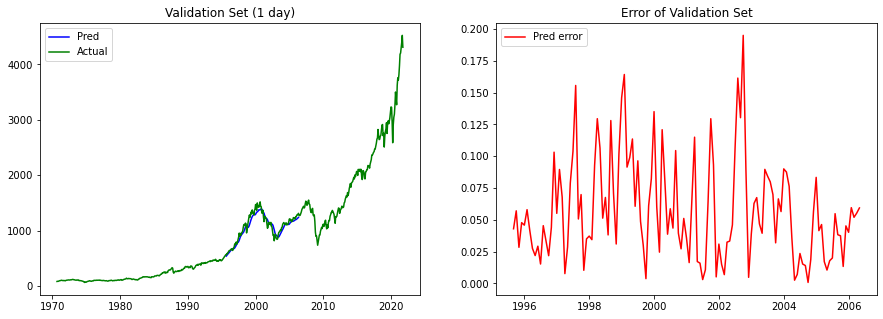

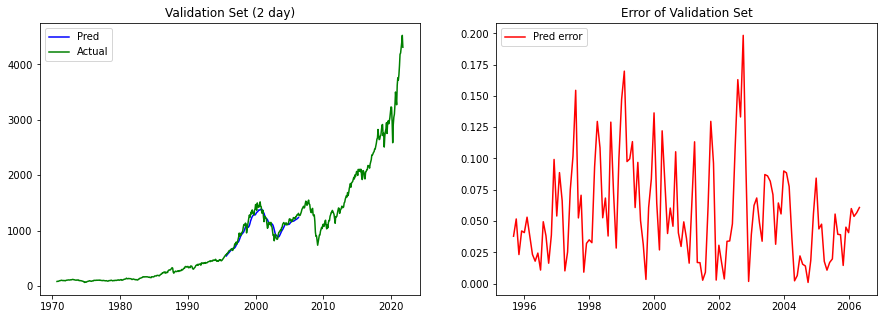

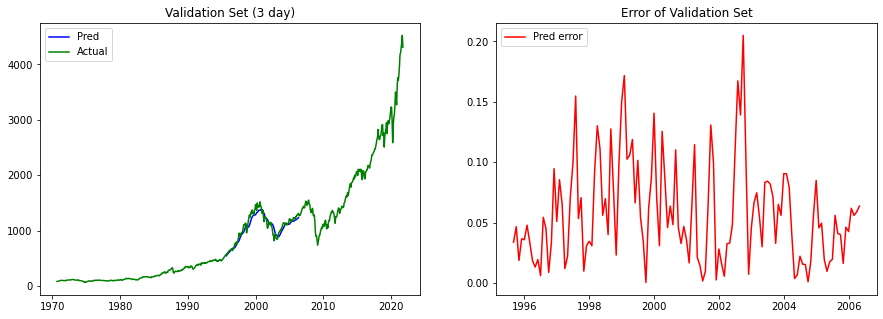

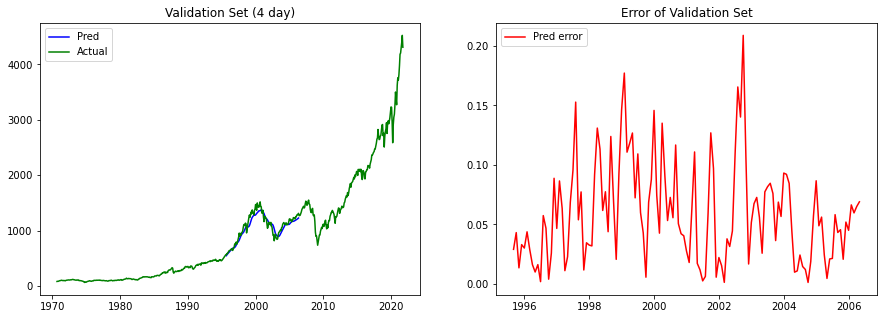

In [18]:
table = []

error = prediction_error(output_plt1, Y_validationplt)
error_dt = pd.DataFrame(data = error)
temp1 = [np.mean(error), np.std(error), error_dt.skew(axis=0).iloc[0], error_dt.kurtosis(axis=0).iloc[0]]
temp1 = np.array(temp1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title("Validation Set (1 day)")
ax1.plot(date_v, output_plt1, color = 'blue', label = 'Pred')
ax1.plot(dateAxis, Y_plt, color = 'green', label = 'Actual')
ax1.legend(loc="upper left")
ax2.set_title("Error of Validation Set")
ax2.plot(date_v, error, color = 'red', label = 'Pred error')
ax2.legend(loc="upper left")

error = prediction_error(output_plt2, Y_validationplt)
error_dt = pd.DataFrame(data = error)
temp2 = [np.mean(error), np.std(error), error_dt.skew(axis=0).iloc[0], error_dt.kurtosis(axis=0).iloc[0]]
temp2 = np.array(temp2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title("Validation Set (2 day)")
ax1.plot(date_v, output_plt2, color = 'blue', label = 'Pred')
ax1.plot(dateAxis, Y_plt, color = 'green', label = 'Actual')
ax1.legend(loc="upper left")
ax2.set_title("Error of Validation Set")
ax2.plot(date_v, error, color = 'red', label = 'Pred error')
ax2.legend(loc="upper left")

error = prediction_error(output_plt3, Y_validationplt)
error_dt = pd.DataFrame(data = error)
temp3 = [np.mean(error), np.std(error), error_dt.skew(axis=0).iloc[0], error_dt.kurtosis(axis=0).iloc[0]]
temp3 = np.array(temp3)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title("Validation Set (3 day)")
ax1.plot(date_v, output_plt3, color = 'blue', label = 'Pred')
ax1.plot(dateAxis, Y_plt, color = 'green', label = 'Actual')
ax1.legend(loc="upper left")
ax2.set_title("Error of Validation Set")
ax2.plot(date_v, error, color = 'red', label = 'Pred error')
ax2.legend(loc="upper left")

error = prediction_error(output_plt4, Y_validationplt)
error_dt = pd.DataFrame(data = error)
temp4 = [np.mean(error), np.std(error), error_dt.skew(axis=0).iloc[0], error_dt.kurtosis(axis=0).iloc[0]]
temp4 = np.array(temp4)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title("Validation Set (4 day)")
ax1.plot(date_v, output_plt4, color = 'blue', label = 'Pred')
ax1.plot(dateAxis, Y_plt, color = 'green', label = 'Actual')
ax1.legend(loc="upper left")
ax2.set_title("Error of Validation Set")
ax2.plot(date_v, error, color = 'red', label = 'Pred error')
ax2.legend(loc="upper left")


temp1 = np.expand_dims(temp1, axis=1)
temp2 = np.expand_dims(temp2, axis=1)
temp3 = np.expand_dims(temp3, axis=1)
temp4 = np.expand_dims(temp4, axis=1)
table = np.concatenate((temp1, temp2, temp3, temp4), axis=1)
ind = ['Mean', 'STD-dev', 'Skewness', 'Kurtosis']
col = ['1 day', '2 day', '3 day', '4 day']
stats=pd.DataFrame(table, columns=col, index=ind).T
stats

In [19]:
xTensor = torch.from_numpy(X_test).float()
output, _ = RNNval(xTensor)

output_plt1 = output.detach().numpy()[:, 0]
output_plt1 = norm.inverse_transform(output_plt1.reshape(-1,1))

output_plt2 = output.detach().numpy()[:, 1]
output_plt2 = norm.inverse_transform(output_plt2.reshape(-1,1))

output_plt3 = output.detach().numpy()[:, 2]
output_plt3 = norm.inverse_transform(output_plt3.reshape(-1,1))

output_plt4 = output.detach().numpy()[:, 3]
output_plt4 = norm.inverse_transform(output_plt4.reshape(-1,1))

Y_testplt = norm.inverse_transform(Y_test[:, :, 0])

,Mean,STD-dev,Skewness,Kurtosis
1 day,0.210687,0.185907,1.483388,1.948458
2 day,0.215265,0.190473,1.483727,1.944046
3 day,0.219795,0.190003,1.417202,1.715413
4 day,0.234791,0.203357,1.421891,1.747512


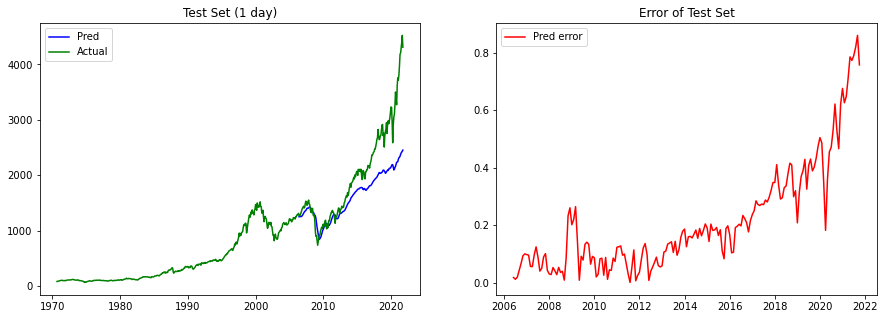

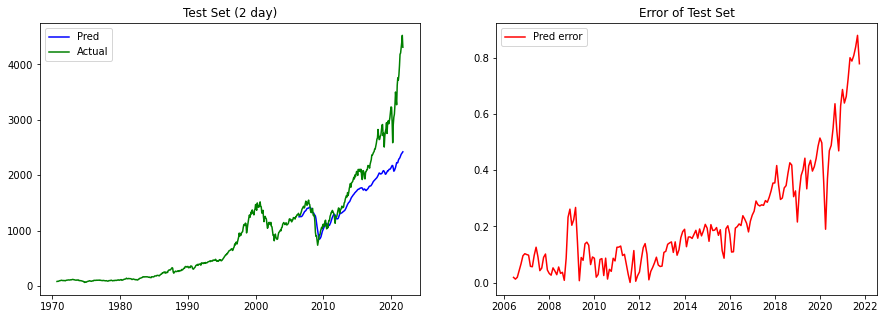

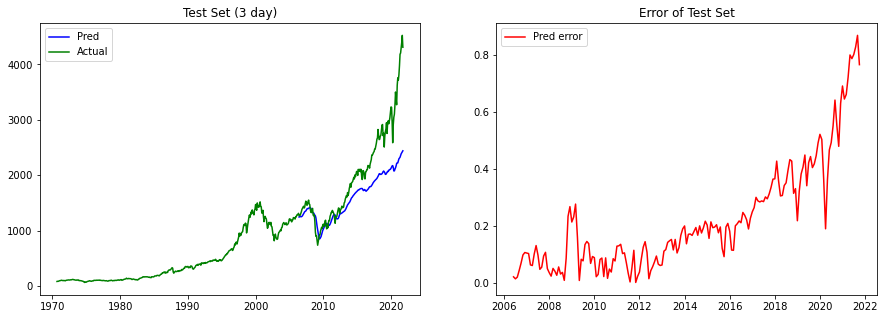

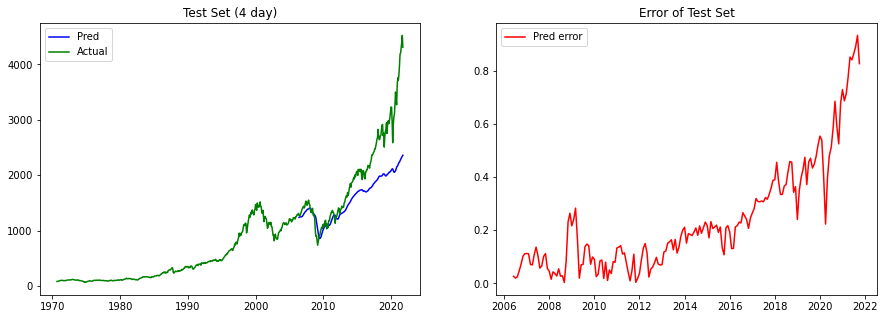

In [20]:
table = []

error = prediction_error(output_plt1, Y_testplt)
error_dt = pd.DataFrame(data = error)
temp1 = [np.mean(error), np.std(error), error_dt.skew(axis=0).iloc[0], error_dt.kurtosis(axis=0).iloc[0]]
temp1 = np.array(temp1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title("Test Set (1 day)")
ax1.plot(date_t, output_plt1, color = 'blue', label = 'Pred')
ax1.plot(dateAxis, Y_plt, color = 'green', label = 'Actual')
ax1.legend(loc="upper left")
ax2.set_title("Error of Test Set")
ax2.plot(date_t, error, color = 'red', label = 'Pred error')
ax2.legend(loc="upper left")

error = prediction_error(output_plt2, Y_testplt)
error_dt = pd.DataFrame(data = error)
temp2 = [np.mean(error), np.std(error), error_dt.skew(axis=0).iloc[0], error_dt.kurtosis(axis=0).iloc[0]]
temp2 = np.array(temp2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title("Test Set (2 day)")
ax1.plot(date_t, output_plt2, color = 'blue', label = 'Pred')
ax1.plot(dateAxis, Y_plt, color = 'green', label = 'Actual')
ax1.legend(loc="upper left")
ax2.set_title("Error of Test Set")
ax2.plot(date_t, error, color = 'red', label = 'Pred error')
ax2.legend(loc="upper left")

error = prediction_error(output_plt3, Y_testplt)
error_dt = pd.DataFrame(data = error)
temp3 = [np.mean(error), np.std(error), error_dt.skew(axis=0).iloc[0], error_dt.kurtosis(axis=0).iloc[0]]
temp3 = np.array(temp3)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title("Test Set (3 day)")
ax1.plot(date_t, output_plt3, color = 'blue', label = 'Pred')
ax1.plot(dateAxis, Y_plt, color = 'green', label = 'Actual')
ax1.legend(loc="upper left")
ax2.set_title("Error of Test Set")
ax2.plot(date_t, error, color = 'red', label = 'Pred error')
ax2.legend(loc="upper left")

error = prediction_error(output_plt4, Y_testplt)
error_dt = pd.DataFrame(data = error)
temp4 = [np.mean(error), np.std(error), error_dt.skew(axis=0).iloc[0], error_dt.kurtosis(axis=0).iloc[0]]
temp4 = np.array(temp4)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title("Test Set (4 day)")
ax1.plot(date_t, output_plt4, color = 'blue', label = 'Pred')
ax1.plot(dateAxis, Y_plt, color = 'green', label = 'Actual')
ax1.legend(loc="upper left")
ax2.set_title("Error of Test Set")
ax2.plot(date_t, error, color = 'red', label = 'Pred error')
ax2.legend(loc="upper left")


temp1 = np.expand_dims(temp1, axis=1)
temp2 = np.expand_dims(temp2, axis=1)
temp3 = np.expand_dims(temp3, axis=1)
temp4 = np.expand_dims(temp4, axis=1)
table = np.concatenate((temp1, temp2, temp3, temp4), axis=1)
ind = ['Mean', 'STD-dev', 'Skewness', 'Kurtosis']
col = ['1 day', '2 day', '3 day', '4 day']
stats=pd.DataFrame(table, columns=col, index=ind).T
stats

# Step 6

In [21]:
def predict(day_index):
    out_temp = np.concatenate( (Y_test[:, :, day_index], Y_test[:, :, day_index], Y_test[:, :, day_index]), axis = 1)
    target = norm.inverse_transform(out_temp)[:, [0]]
    error_res_all = []
    for sigma in stdev:
        noisy_data = NoisyTesting(X_test, sigma)
        inputs = Variable(torch.from_numpy(noisy_data).float())
        output, _ = RNNval(inputs)
        out_temp = np.concatenate((output.detach().numpy()[:, [day_index]], 
                                   output.detach().numpy()[:, [day_index]],  
                                   output.detach().numpy()[:, [day_index]]), axis=1)
        predicted_price = norm.inverse_transform(out_temp)[:, [0]]
        error = prediction_error(target, predicted_price)
        error_res_all.append(error.reshape(-1))
    return error_res_all

In [22]:
cmaps= ['red','purple', 'green', 'orange',  'yellow', 'pink', 'grey', 'brown', 'black','blue' ]
def FullGraphing(day):
    plt.figure(1, figsize=(15, 5))
    for i in range(len(stdev)): 
        #print(np.shape(date_test))
        #print(np.shape(error_res_all[i]))
        #print(np.shape(cmaps[i]))
        plt.plot(np.squeeze(date_test), error_res_all[i], color=cmaps[i], lw=1, label = stdev[i], marker= 'o', linestyle='None')  

    plt.xlabel('Date')
    plt.ylabel('Prediction error')
    plt.title('Prediction error with Different Noise Levels (next ' +day+ ' day)')
    plt.legend(loc="lower right") 

In [23]:
def IndividualGraphing(day):
    for i in range(len(stdev)): 
        plt.figure(1, figsize=(15, 5))
        plt.plot(np.squeeze(date_test), error_res_all[i], color=cmaps[i], lw=1, label = stdev[i], marker= 'o', linestyle='None')  
        plt.xlabel('Date')
        plt.ylabel('Prediction error')
        plt.title('Prediction error with Different Noise Levels (next '+day+' day)')
        plt.legend(loc="lower right")  
        plt.show()

In [24]:
print("NOISY")
stdev = [0,0.001, 0.002, 0.003, 0.005, 0.01, 0.02, 0.03, 0.05,0.1]

def NoisyTesting(dataset, sigma):
    noisy_data = np.ndarray(shape=dataset.shape, dtype=np.float32)
    #set seed for random numbers
    random.seed(1)
    for i in range(6):
        s = np.random.normal(0, sigma, 20)
        index = random.sample(list(range(180)), 20)
        noisy_data[i] = dataset[i]
        noisy_data[index, i, 0] = noisy_data[index, i, 0] + s
    return noisy_data

NOISY


,0.000,0.001,0.002,0.003,0.005,0.010,0.020,0.030,0.050,0.100
01/08/2006,0.017036,0.016903,0.017095,0.016890,0.017912,0.015869,0.015641,0.016925,0.016000,0.011430
01/09/2006,0.011106,0.010825,0.010669,0.011857,0.008838,0.008476,0.026689,0.012123,0.018930,0.053391
01/10/2006,0.018070,0.018070,0.018070,0.018070,0.018070,0.018070,0.018070,0.018070,0.018070,0.018070
01/11/2006,0.040340,0.040037,0.040312,0.040548,0.040696,0.040649,0.027050,0.034017,0.060878,0.041470
01/12/2006,0.061959,0.061959,0.061959,0.061959,0.061959,0.061959,0.061959,0.061959,0.061959,0.061959
...,...,...,...,...,...,...,...,...,...,...
01/08/2021,0.531715,1.693851,1.264892,0.985181,1.268887,1.053809,0.543790,1.075403,1.264892,0.793034
01/09/2021,0.799648,0.314875,1.269833,0.902770,0.193615,0.981221,0.103733,0.969511,1.269833,1.010778
01/10/2021,1.229507,0.984896,0.539375,1.159530,1.591939,0.991917,1.313975,1.081160,0.539375,1.035022
01/11/2021,0.742486,0.985322,1.242427,1.463045,0.174293,0.916072,0.534588,0.970368,1.242427,1.028915


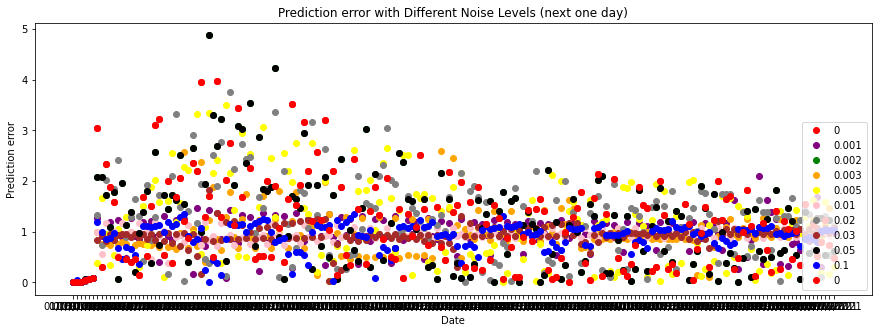

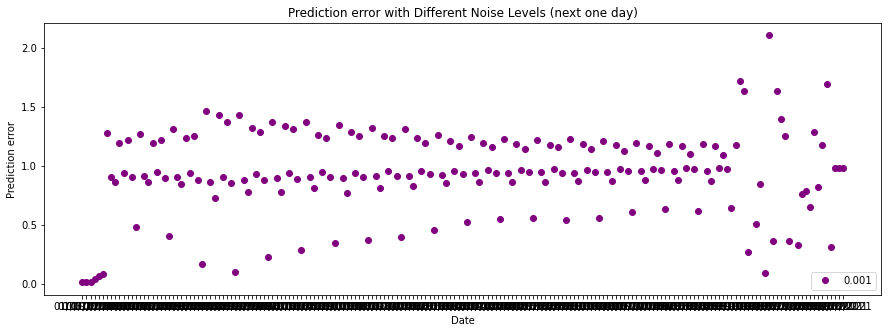

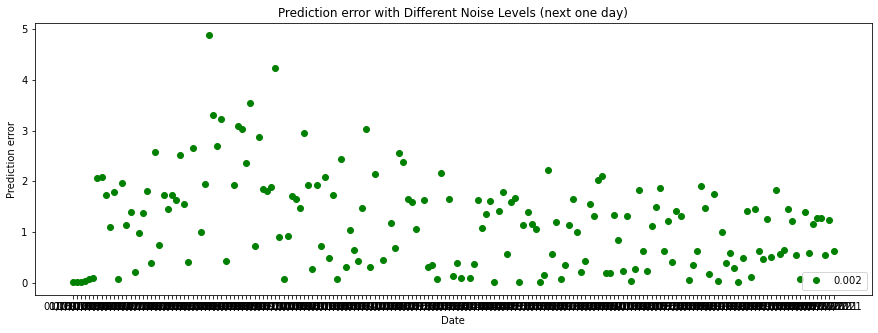

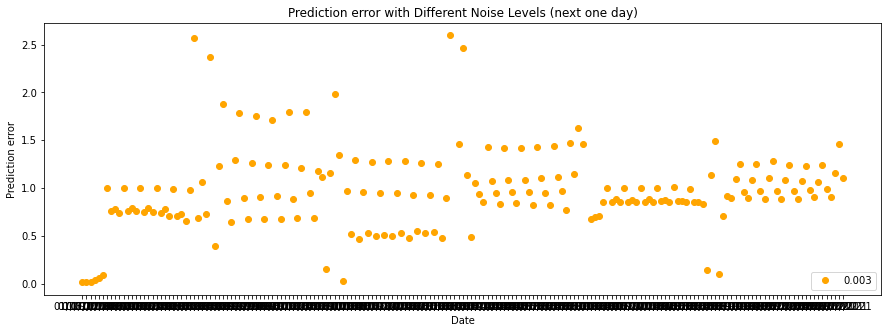

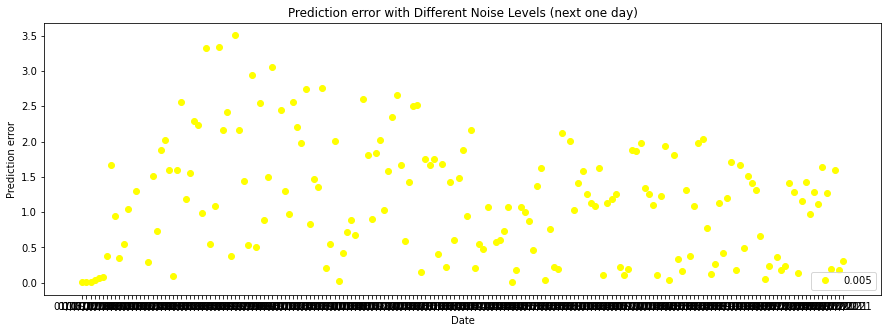

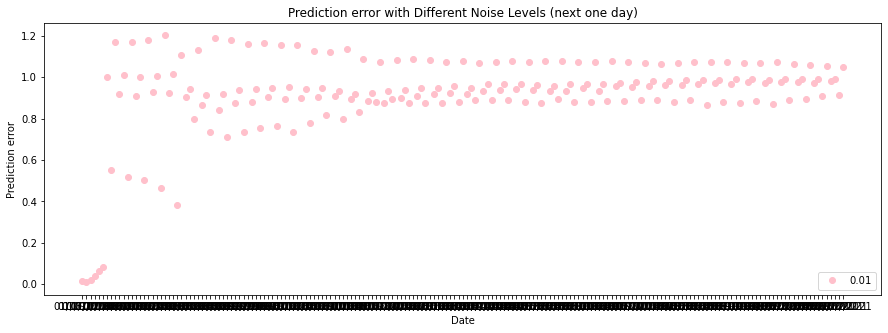

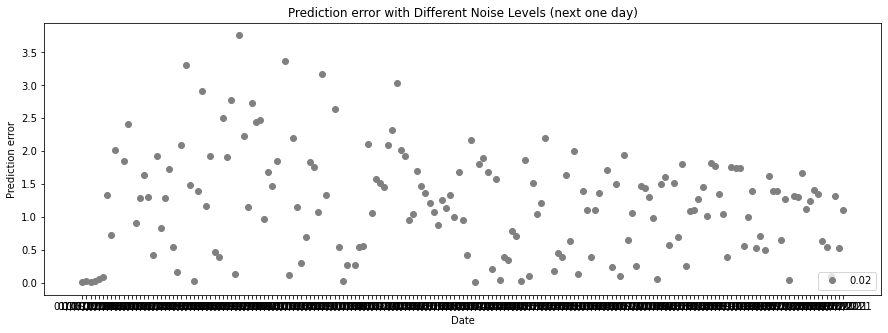

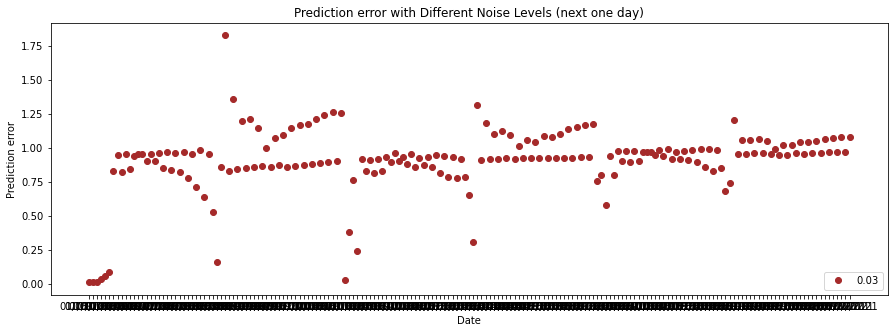

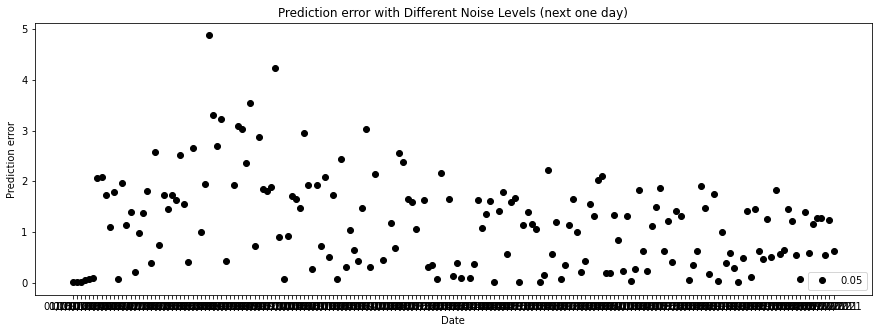

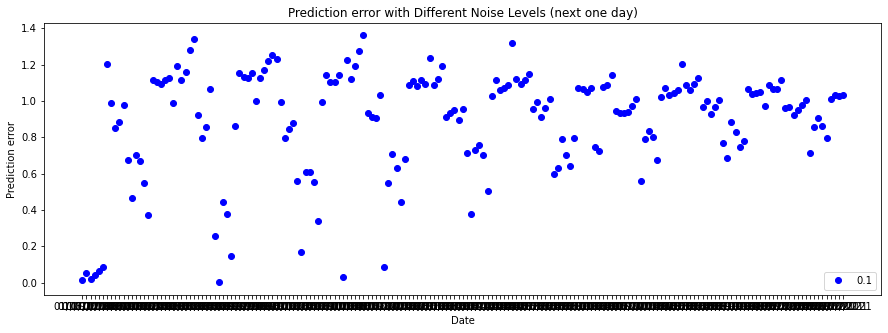

In [25]:
error_res_all=predict(0)

labels = date_test[:,0]
df_error=pd.DataFrame(error_res_all, columns=labels, index=stdev).T
display(df_error)

FullGraphing("one")
IndividualGraphing("one")

,0.000,0.001,0.002,0.003,0.005,0.010,0.020,0.030,0.050,0.100
01/08/2006,0.018002,0.018016,0.017862,0.018251,0.018626,0.018096,0.017910,0.015879,0.013200,0.016723
01/09/2006,0.016879,0.017257,0.016830,0.016766,0.017842,0.015672,0.019399,0.026201,0.008038,0.048477
01/10/2006,0.038680,0.038680,0.038680,0.038680,0.038680,0.038680,0.038680,0.038680,0.038680,0.038680
01/11/2006,0.063698,0.063715,0.063447,0.063861,0.065331,0.067522,0.060940,0.073874,0.037652,0.044887
01/12/2006,0.091392,0.091392,0.091392,0.091392,0.091392,0.091392,0.091392,0.091392,0.091392,0.091392
...,...,...,...,...,...,...,...,...,...,...
01/08/2021,0.797722,0.350118,0.840483,0.350118,0.840483,0.350118,0.840483,0.350118,0.840483,0.350118
01/09/2021,1.007200,0.364573,1.014773,0.364573,1.014773,0.364573,1.014773,0.364573,1.014773,0.364573
01/10/2021,1.031276,0.382475,1.031760,0.382475,1.031760,0.382475,1.031760,0.382475,1.031760,0.382475
01/11/2021,1.027347,0.351633,1.088724,0.351633,1.088724,0.351633,1.088724,0.351633,1.088724,0.351633


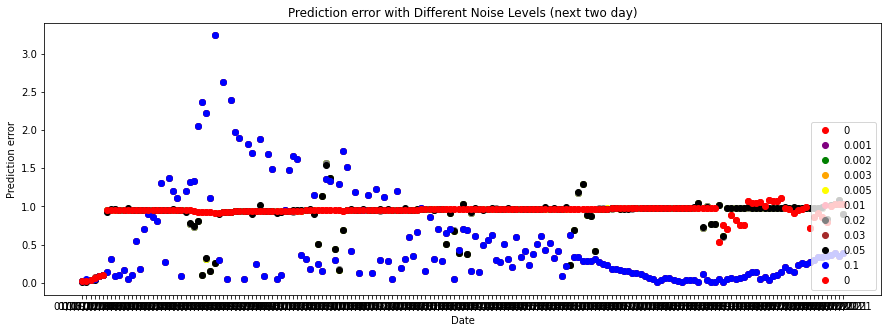

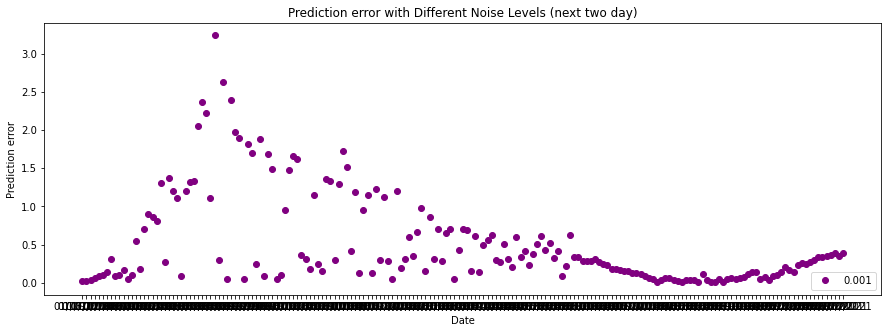

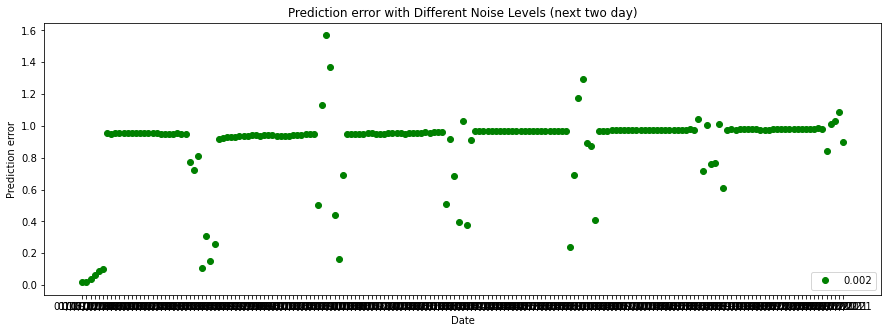

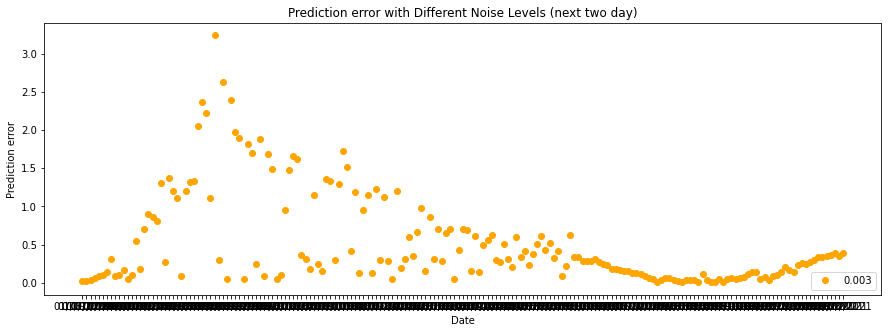

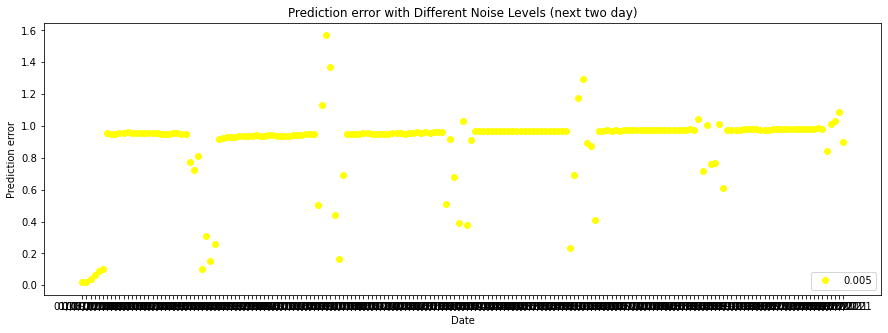

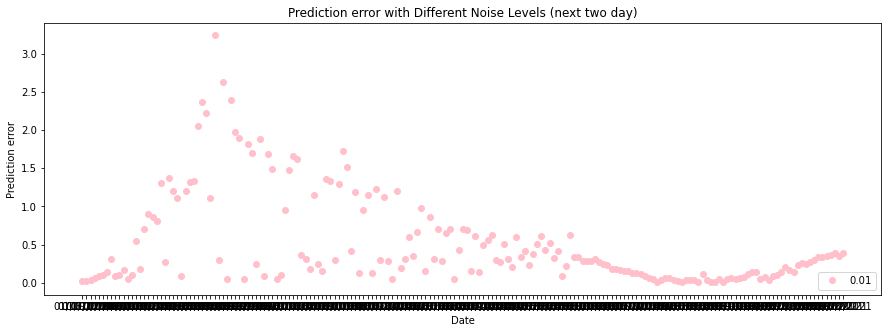

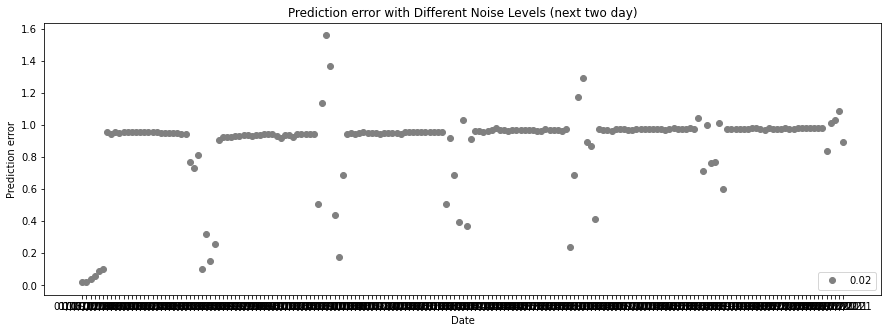

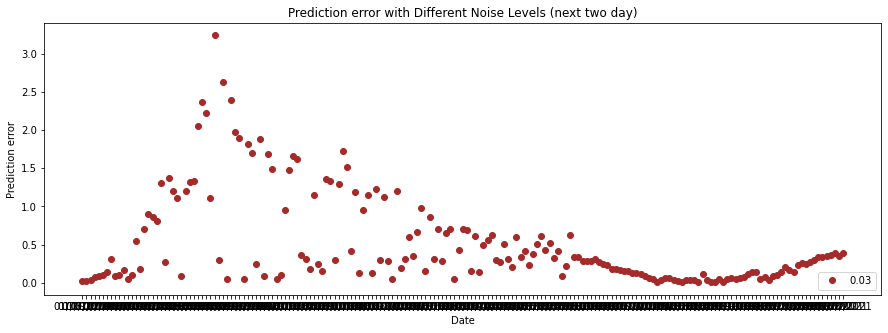

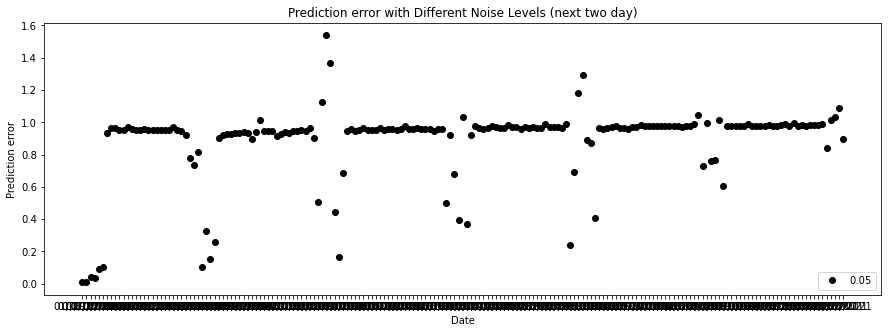

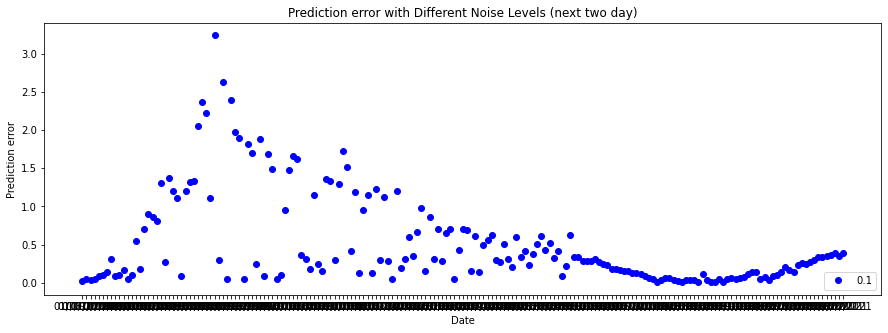

In [26]:
error_res_all=predict(1)

output.detach().numpy()[:,0:1]
df_error=pd.DataFrame(error_res_all, columns=labels, index=stdev).T
display(df_error)

FullGraphing("two")
IndividualGraphing("two")

,0.000,0.001,0.002,0.003,0.005,0.010,0.020,0.030,0.050,0.100
01/08/2006,0.025579,0.025666,0.025600,0.025449,0.025070,0.027503,0.024989,0.028893,0.030492,0.028354
01/09/2006,0.039227,0.038629,0.040312,0.039330,0.039543,0.044115,0.043884,0.038998,0.049788,0.040536
01/10/2006,0.062931,0.062931,0.062931,0.062931,0.062931,0.062931,0.062931,0.062931,0.062931,0.062931
01/11/2006,0.093255,0.093693,0.093696,0.092462,0.091753,0.092532,0.080376,0.108132,0.098197,0.140529
01/12/2006,0.107855,0.107855,0.107855,0.107855,0.107855,0.107855,0.107855,0.107855,0.107855,0.107855
...,...,...,...,...,...,...,...,...,...,...
01/08/2021,0.044290,0.551389,0.638525,0.551389,0.079097,0.551389,0.654962,0.551389,0.741601,0.551389
01/09/2021,0.071216,1.237351,0.559884,1.237351,0.787267,1.237351,0.688030,1.237351,0.949398,1.237351
01/10/2021,0.024828,0.713611,0.522717,0.713611,0.984628,0.713611,0.927614,0.713611,0.751466,0.713611
01/11/2021,0.087894,0.628280,0.603174,0.628280,0.985604,0.628280,0.818403,0.628280,0.768229,0.628280


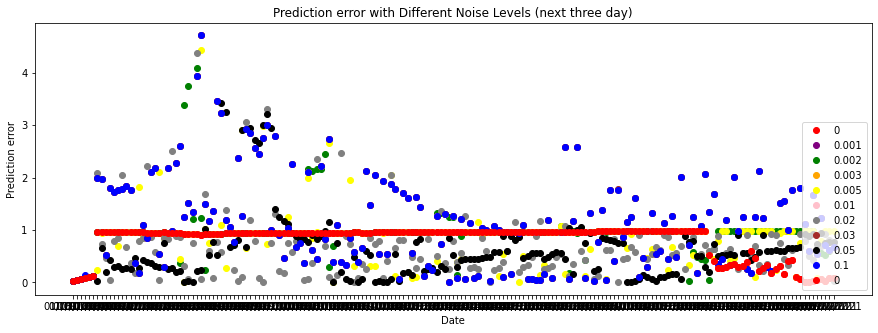

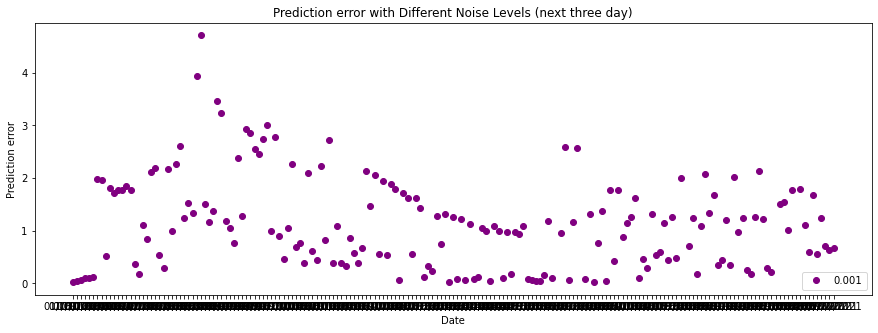

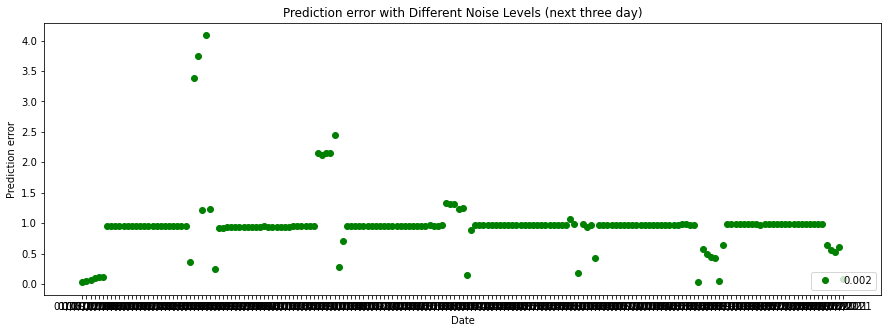

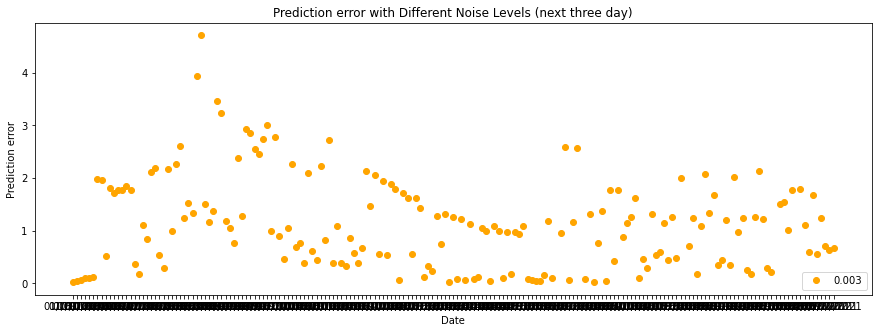

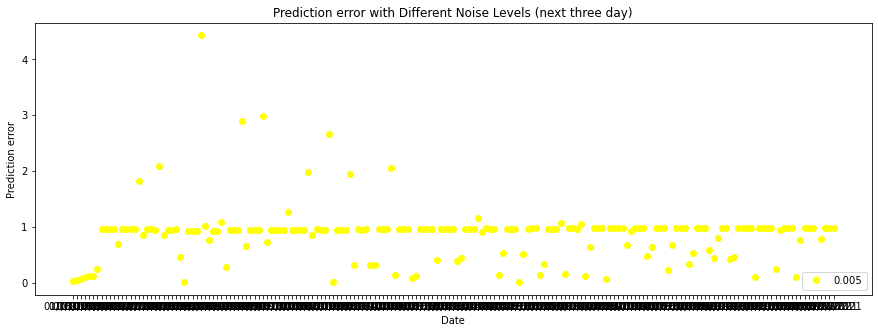

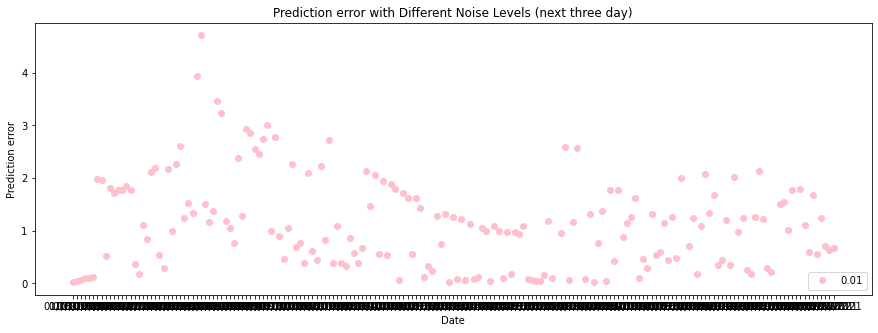

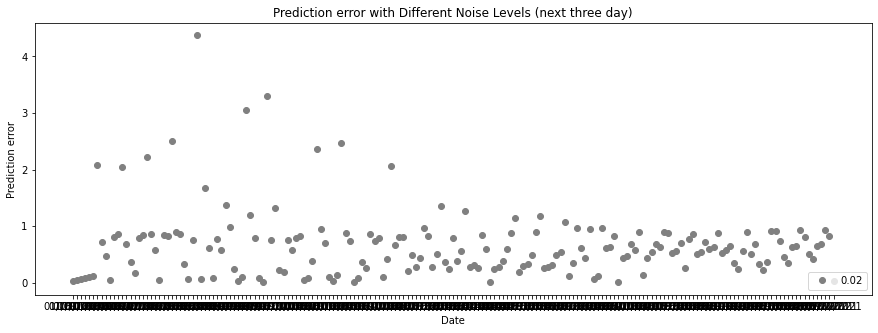

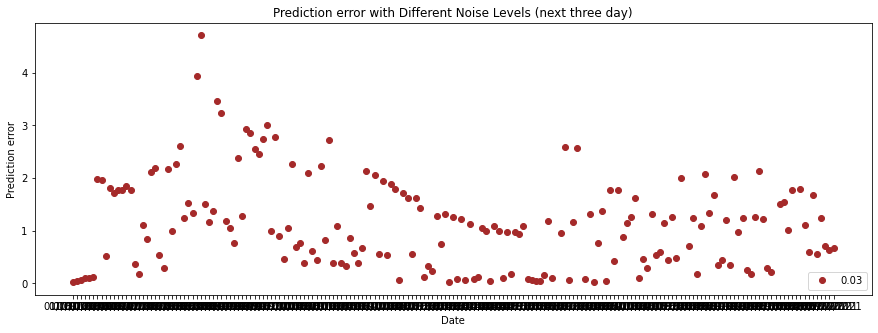

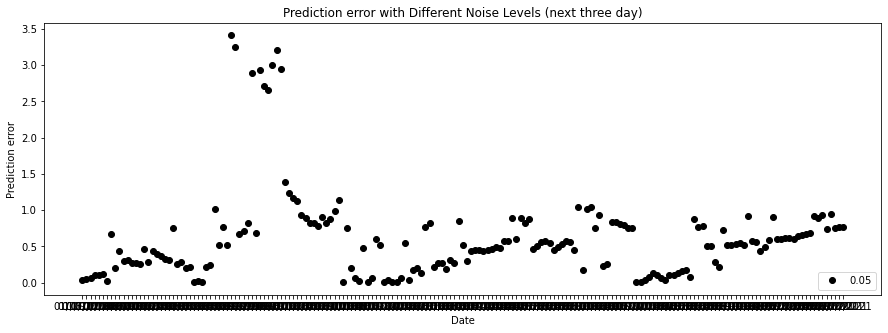

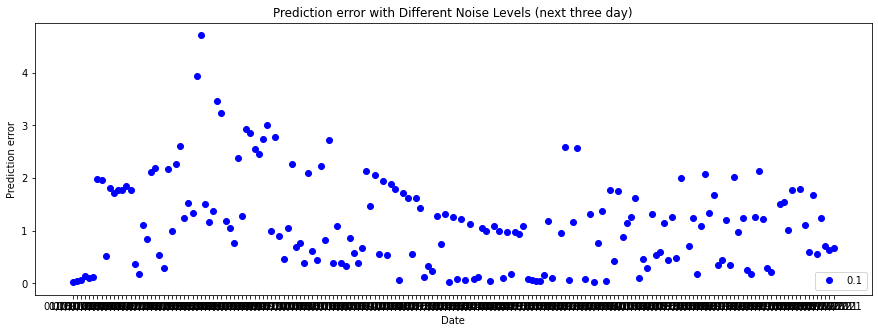

In [27]:
error_res_all=predict(2)

output.detach().numpy()[:,0:2]
df_error=pd.DataFrame(error_res_all, columns=labels, index=stdev).T
display(df_error)

FullGraphing("three")
IndividualGraphing("three")

,0.000,0.001,0.002,0.003,0.005,0.010,0.020,0.030,0.050,0.100
01/08/2006,0.051436,0.051603,0.051657,0.051468,0.051772,0.052613,0.049989,0.045171,0.032218,0.067488
01/09/2006,0.068135,0.068067,0.068058,0.069070,0.068447,0.069541,0.066861,0.068085,0.076733,0.094201
01/10/2006,0.095873,0.095873,0.095873,0.095873,0.095873,0.095873,0.095873,0.095873,0.095873,0.095873
01/11/2006,0.111014,0.111212,0.111589,0.110224,0.109795,0.108843,0.110010,0.103943,0.113036,0.094903
01/12/2006,0.121409,0.121409,0.121409,0.121409,0.121409,0.121409,0.121409,0.121409,0.121409,0.121409
...,...,...,...,...,...,...,...,...,...,...
01/08/2021,NaN,1.004144,1.359387,1.004144,1.359387,1.004144,1.359387,1.004144,1.359387,1.004144
01/09/2021,1.192946,0.736181,0.771876,0.736181,0.771876,0.736181,0.771876,0.736181,0.771876,0.736181
01/10/2021,0.614305,0.699324,0.784543,0.699324,0.784543,0.699324,0.784543,0.699324,0.784543,0.699324
01/11/2021,0.448552,0.577836,0.613215,0.577836,0.613215,0.577836,0.613215,0.577836,0.613215,0.577836


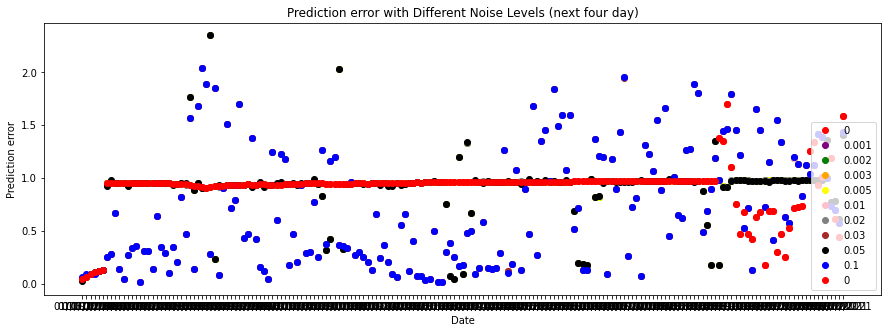

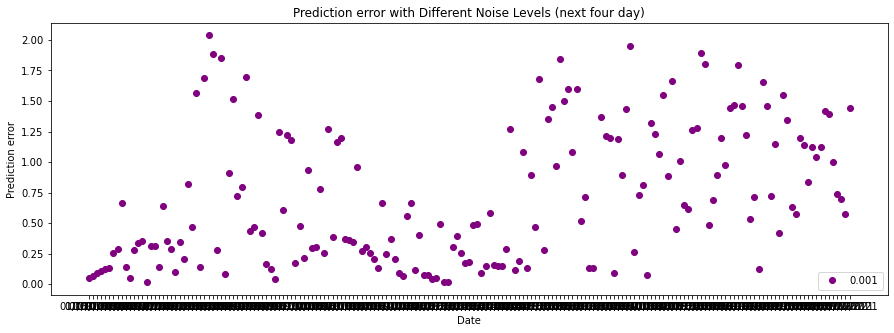

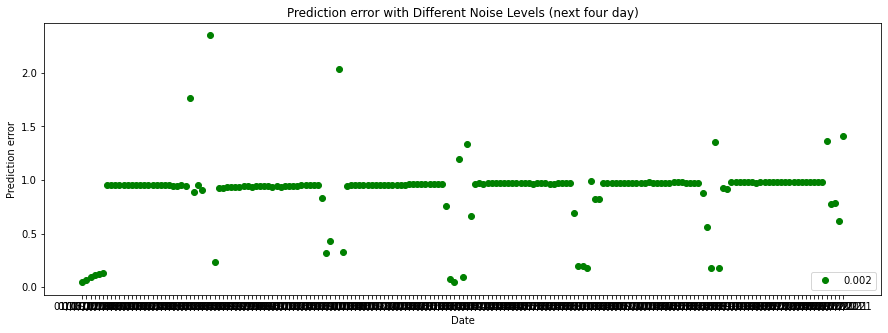

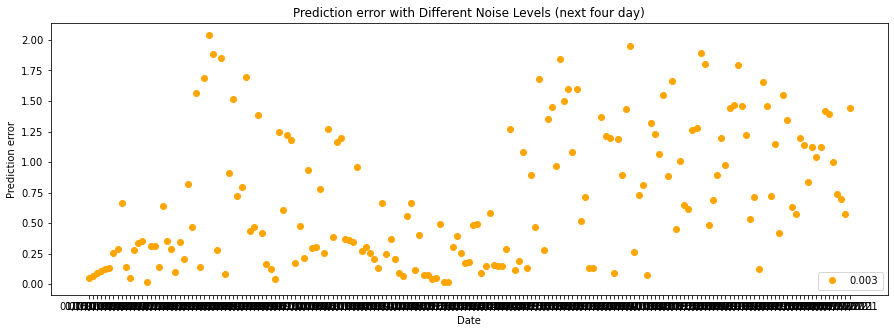

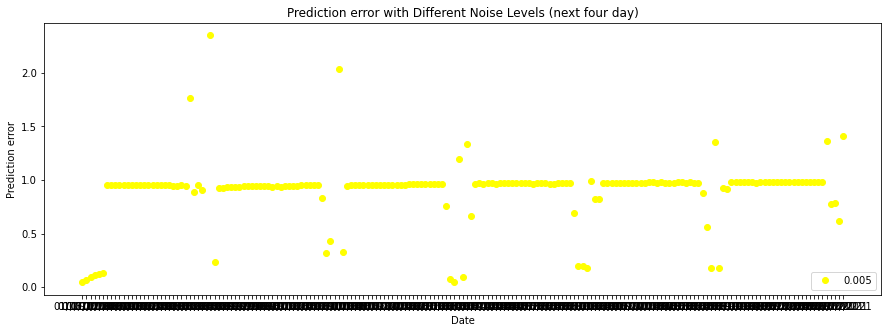

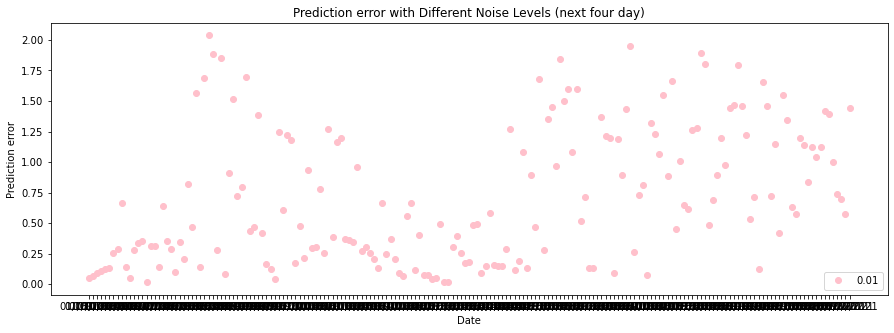

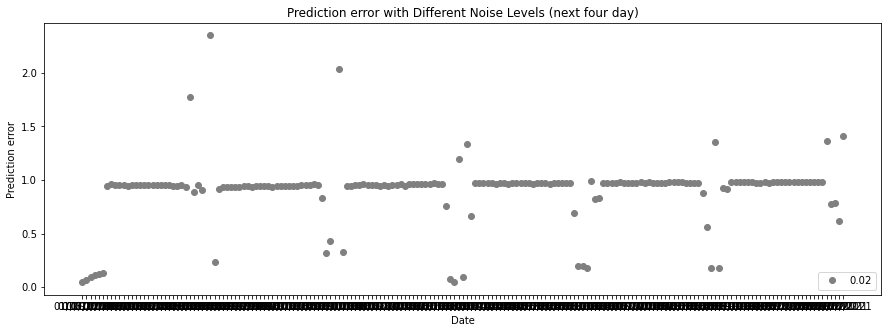

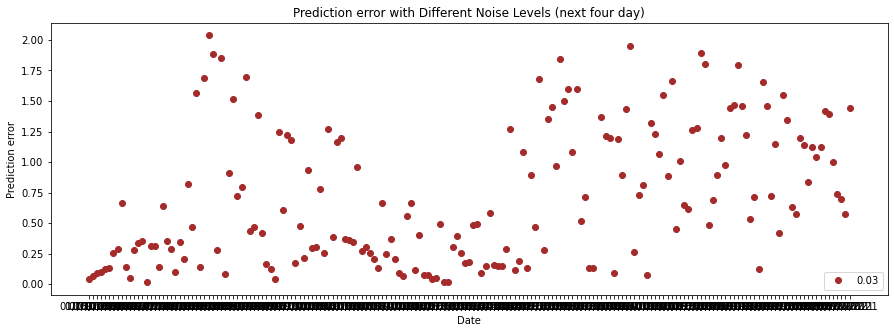

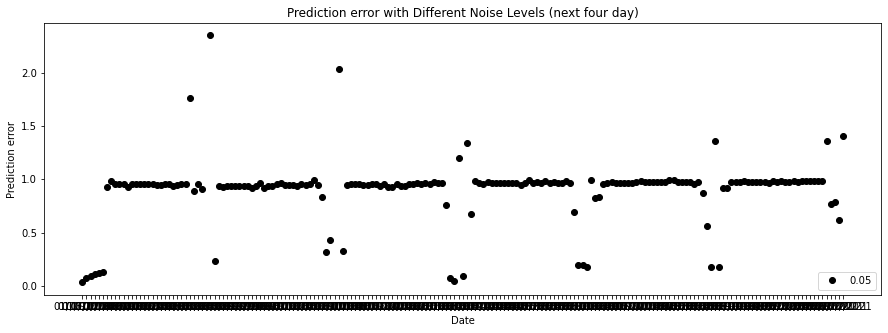

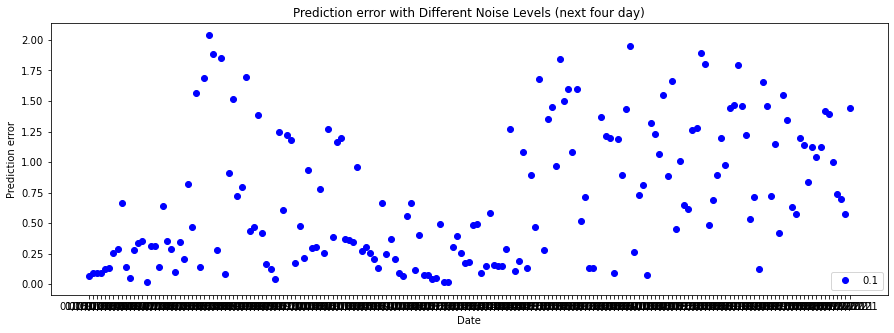

In [28]:
error_res_all=predict(3)

output.detach().numpy()[:,0:3]
df_error=pd.DataFrame(error_res_all, columns=labels, index=stdev).T
display(df_error)

FullGraphing("four")
IndividualGraphing("four")